# Causal Data Science Week 6 Tutorial

In this tutorial we will practice how to learn a causal graph using score based structure learning with the GES algorithm. We will use the python implementation of the algorithm from the package GES. You can also choose to use the GES implementation in CDT, which is a python wrapper of an R script.

## GES algorithm

Greedy Equivalence Search (GES) (https://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf) is a score-based causal discovery algorithm. We consider the score $S(G,D)$ of a graph $G$ given the data $D$ to be computed according to the Bayesian Information Criterion (BIC) score. The algorithm constists of three steps:
1. Start with an empty CPDAG representing a MEC
2. Forward phase: add edges one by one until local maxima in BIC
3. Backward phase: remove edges one by one until local maxima in BIC

The resulting intermediate models during the forward and backward phases are mapped to their corresponding Markov equivalence classes


In [1]:
# import necessary packages
import cdt
import dowhy.graph_learners.ges as dowhy_ges
import ges
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

np.random.seed(0)

Detecting 1 CUDA device(s).


For our experiment, we use synthetic data generated by the same SCM that we used in Tutorial 5, shown below.
$$
\begin{aligned}
X_1 &\leftarrow \epsilon_1 & \epsilon_1 &\sim \mathcal N(0,1)\\
X_2 &\leftarrow \epsilon_2 & \epsilon_2 &\sim \mathcal N(0,1)\\
X_3 &\leftarrow X_1 + X_2 + \epsilon_3 & \epsilon_3 &\sim \mathcal N(0,0.7)\\
X_4 &\leftarrow 2 X_1 + \epsilon_4 & \epsilon_4 &\sim \mathcal N(0,1.5)\\
X_5 &\leftarrow 3 X_3 + \epsilon_5 & \epsilon_5 &\sim \mathcal N(0,1)\\
\end{aligned}
$$

In [13]:
df = pd.read_csv('lucas0_train.csv')
df

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [7]:
n_samples=10000

eps1 = np.random.normal(0, 1, n_samples)
eps2 = np.random.normal(0, 2, n_samples)
eps3 = np.random.normal(0, 0.7, n_samples)
eps4 = np.random.normal(0, 1.5, n_samples)
eps5 = np.random.normal(0, 1, n_samples)

x1 = eps1
x2 = eps2
x3 = x1 + x2 + eps3
x4 = 2 * x1 + eps4
x5 = 3 * x3 + eps5

#df = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4,'x5': x5})

As a reference, we can manually draw the true causal graph according to the SCM.

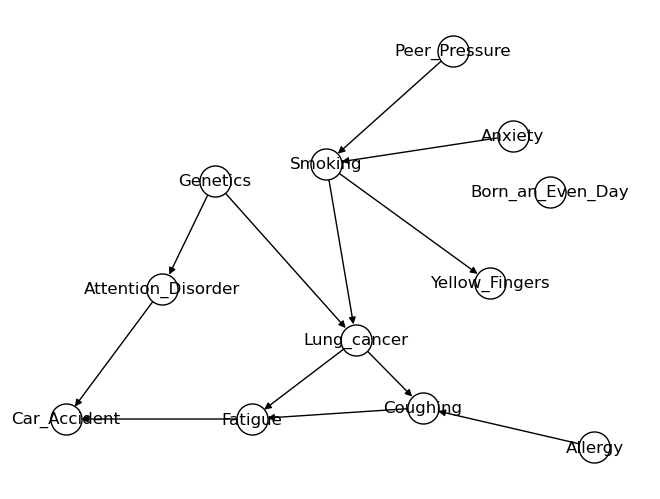

In [10]:
pos = {'Smoking':(4, 5),
 'Yellow_Fingers':(6.2,2.9),
 'Anxiety':(6.5, 5.5),
 'Peer_Pressure':(5.7, 7),
 'Genetics':(2.5, 4.7),
 'Attention_Disorder':(1.8,2.8),
 'Born_an_Even_Day':(7, 4.5),
 'Car_Accident':(0.5,0.5),
 'Fatigue':(3, 0.5),
 'Allergy':(7.6,0.0),
 'Coughing':(5.3, 0.7),
 'Lung_cancer':(4.4,1.9)}

nodes = list(pos.keys())

true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
true_graph.add_edges_from([('Smoking', 'Lung_cancer'),
                           ('Smoking', 'Yellow_Fingers'),
                           ('Anxiety', 'Smoking'),
                           ('Peer_Pressure', 'Smoking'),
                           ('Genetics', 'Lung_cancer'),
                           ('Lung_cancer', 'Coughing'),
                           ('Lung_cancer', 'Fatigue'),
                           ('Genetics', 'Attention_Disorder'),
                           ('Allergy', 'Coughing'),
                           ('Coughing', 'Fatigue'),
                           ('Fatigue', 'Car_Accident'),
                           ('Attention_Disorder', 'Car_Accident'),])

nx.draw(true_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

### Step-by-step
Before simply running GES with a simple function call on our data, let's take a closer look at the learning process. We first select our score function to be the Gaussian BIC score (this is the only score function implemented in the `ges` package) and create the initial empty CPDAG, which will be represented by adjacency matrices throughout the algorithm. Following this, we run the forward phase and then the backward phase, each until we cannot add or remove an edge that increases the score of the candidate CPDAG. Each time an edge is added or removed, the resulting DAG and its corresponding score change is computed. If the score change is positive, then we update the CPDAG according to the found DAG, and continue the phase.

In [12]:
score_class

In [14]:
# Containers to hold data from intermediate steps
inter_adjs = []
inter_scores = []
inter_phases = []

# Initialization
score_class = ges.scores.gauss_obs_l0_pen.GaussObsL0Pen(df.to_numpy()) # initalize the Gaussian BIC score (with numpy array)
cpdag = np.zeros((len(nodes), len(nodes))) # Initialize empty CPDAG as adjacency matrix
score = 0

# Run phases
for phase in [ges.forward_step, ges.backward_step]: # Run forward then backward phase
    print('GES {} phase start'.format(phase.__name__))
    while True: # Continue while we can increase the score in the current phase
        score_change, dag = phase(cpdag, score_class, 2) # Compute best possible score change and corresponding DAG
        if score_change > 0: # The score can be increased
            cpdag = ges.utils.pdag_to_cpdag(dag) # Get CPDAG of DAG
            score += score_change # Update total score

            # Save intermediate state
            inter_adjs.append(cpdag)
            inter_scores.append(score)
            inter_phases.append(phase.__name__)

            # Print intermediate state
            print('New score: {0:.4f}'.format(score))
            [print(row) for row in cpdag]
            print()
        else: # The score cannot be increased thus we end the phase
            break

GES forward_step phase start
  132 candidate edges
    insert(0,1,[]) -> 912.9918467260049511
    insert(0,2,[]) -> 171.5996095573120783
    insert(0,3,[]) -> 18.6927683461440779
    insert(0,4,[]) -> -3.6962513565372319
    insert(0,5,[]) -> -3.7839777450622023
    insert(0,6,[]) -> -3.2951630342355998
    insert(0,7,[]) -> -1.1466550626828393
    insert(0,8,[]) -> 23.0179784806930456
    insert(0,9,[]) -> -2.4975113759028318
    insert(0,10,[]) -> 67.5522694228510545
    insert(0,11,[]) -> 272.6399116839509134
    insert(1,0,[]) -> 912.9918467260047237
    insert(1,2,[]) -> 96.1028874348315867
    insert(1,3,[]) -> 9.4300616820461300
    insert(1,4,[]) -> -3.7834982539768589
    insert(1,5,[]) -> -3.7547288647367623
    insert(1,6,[]) -> -3.7614478164800857
    insert(1,7,[]) -> -1.3645168521697997
    insert(1,8,[]) -> 11.8692776045805886
    insert(1,9,[]) -> -1.5591612687436509
    insert(1,10,[]) -> 40.1343546809353029
    insert(1,11,[]) -> 149.5551086913309291
    insert(2,0,[]

The output above shows that at each step in each phase, a set of candidate edges that we can insert/delete is considered, and their corresponding score changes of the insertion or deletion is calculated. The algorithm selects the best valid operation and returns the score change, and the corresponding candidate DAG. As we can see, the algorithm can add four edges to the CPDAG, but any fifth edge would result in a decreased score. After this, the algorithm cannot delete any edges for the same reason.

We can also visualize the whole process by drawing the intermediate CPDAG at each step. We can see how the number of edges grows during forward steps, and how the algorithm transitions between CPDAGs defining different v-structures (from step 2 to 3).

In [15]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

def draw_graph(G):
    pos_a = pos
    pos_nodes = nudge(pos_a, 0.0, -0.45)

    fig, ax = plt.subplots(1, figsize=(12,12))
    ax.margins(0.2)
    nx.draw(G, ax=ax, pos=pos, with_labels=False, node_size=500, node_color='w', edgecolors='black', edge_color=colors)
    nx.draw_networkx_labels(G, ax=ax, pos=pos_nodes, font_size=18)

In [16]:
inter_adjs

[array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
import os

os.mkdir('GES')

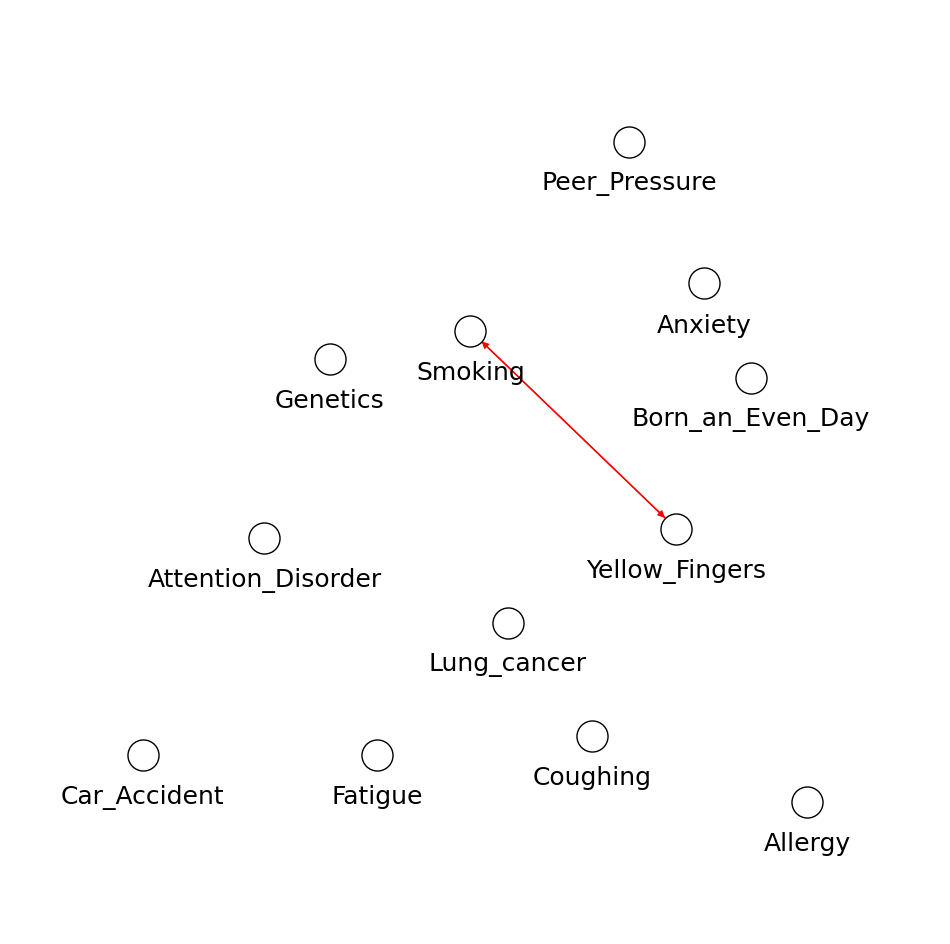

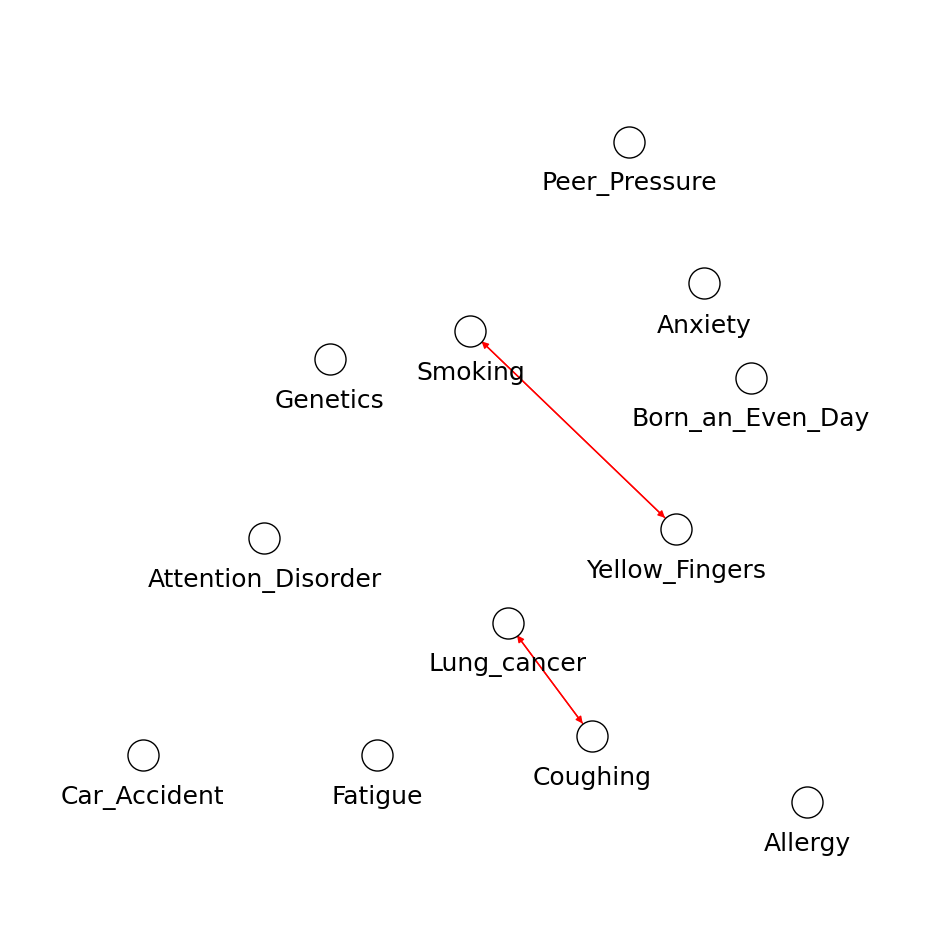

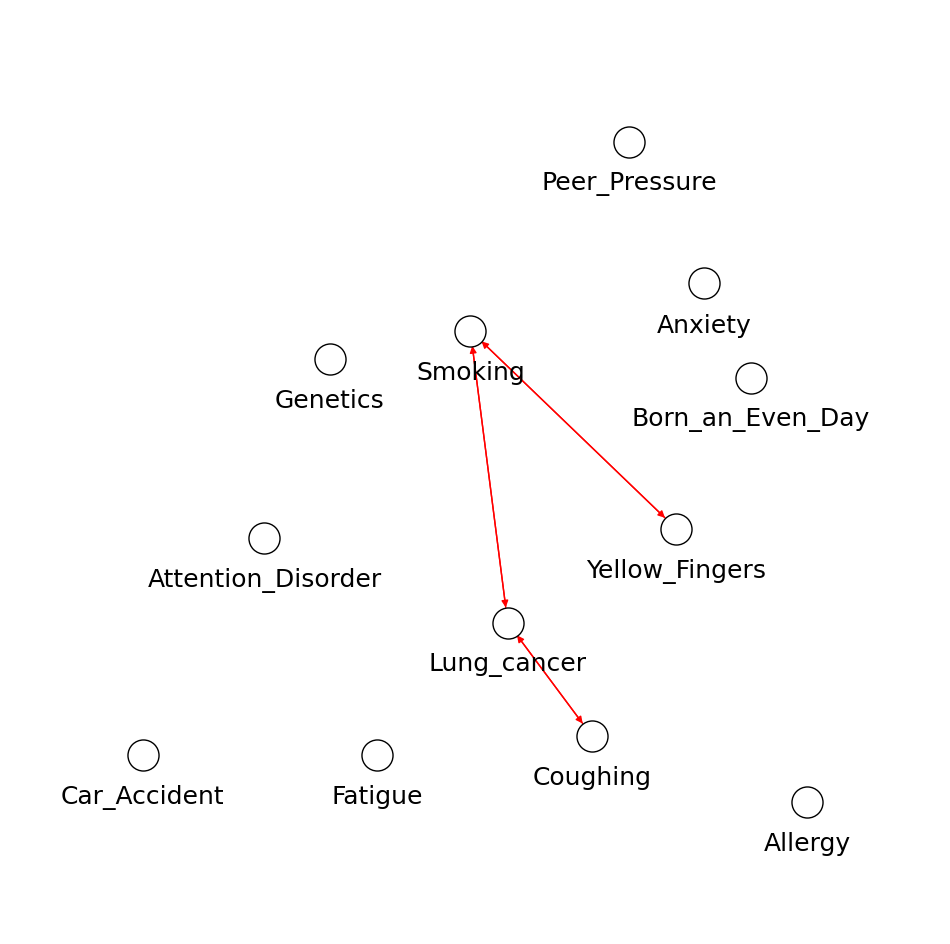

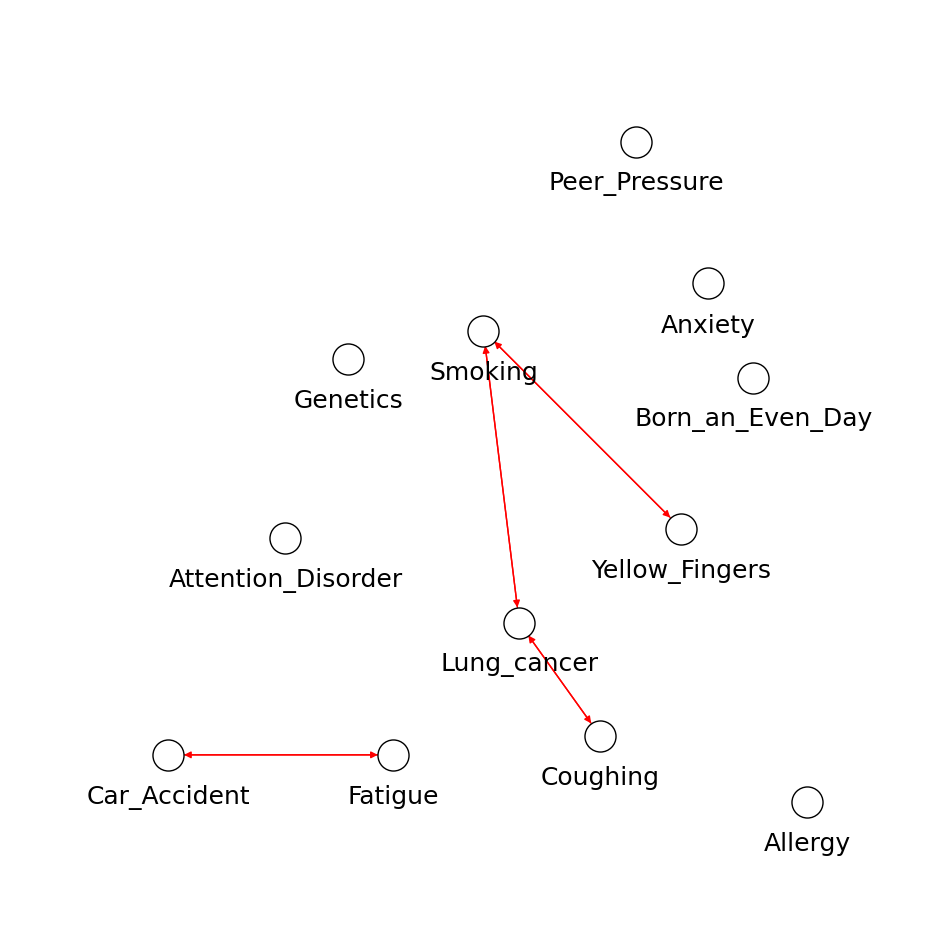

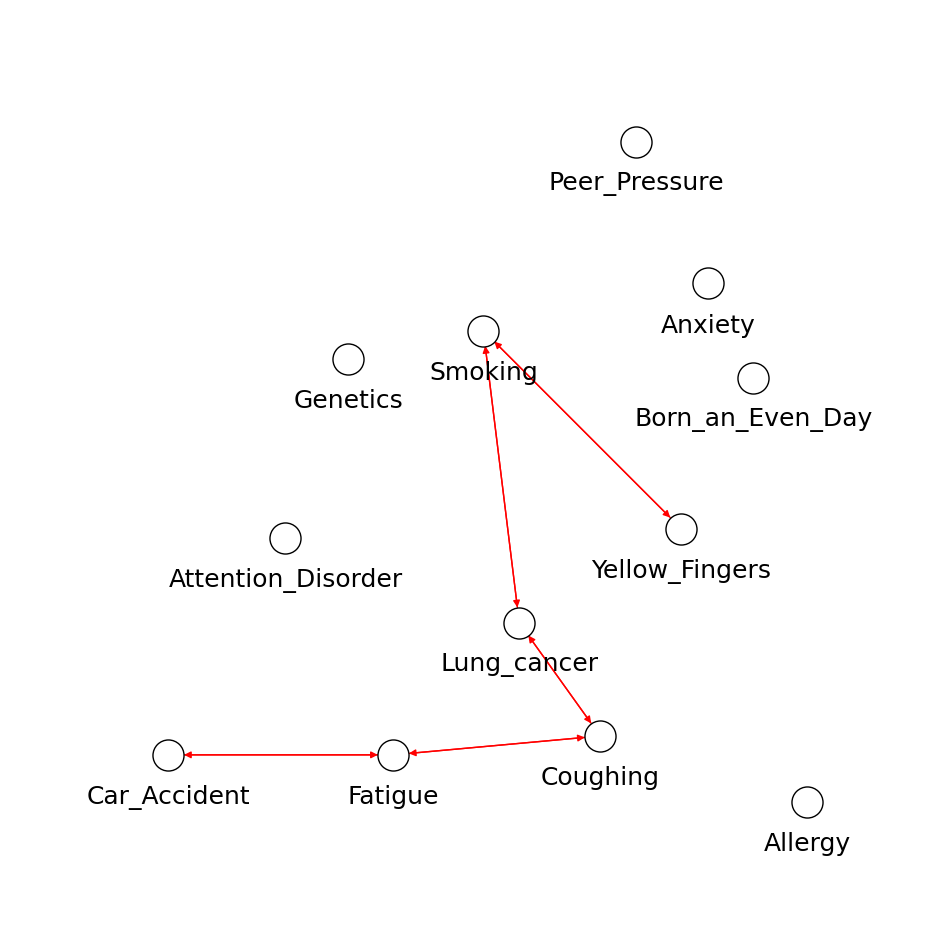

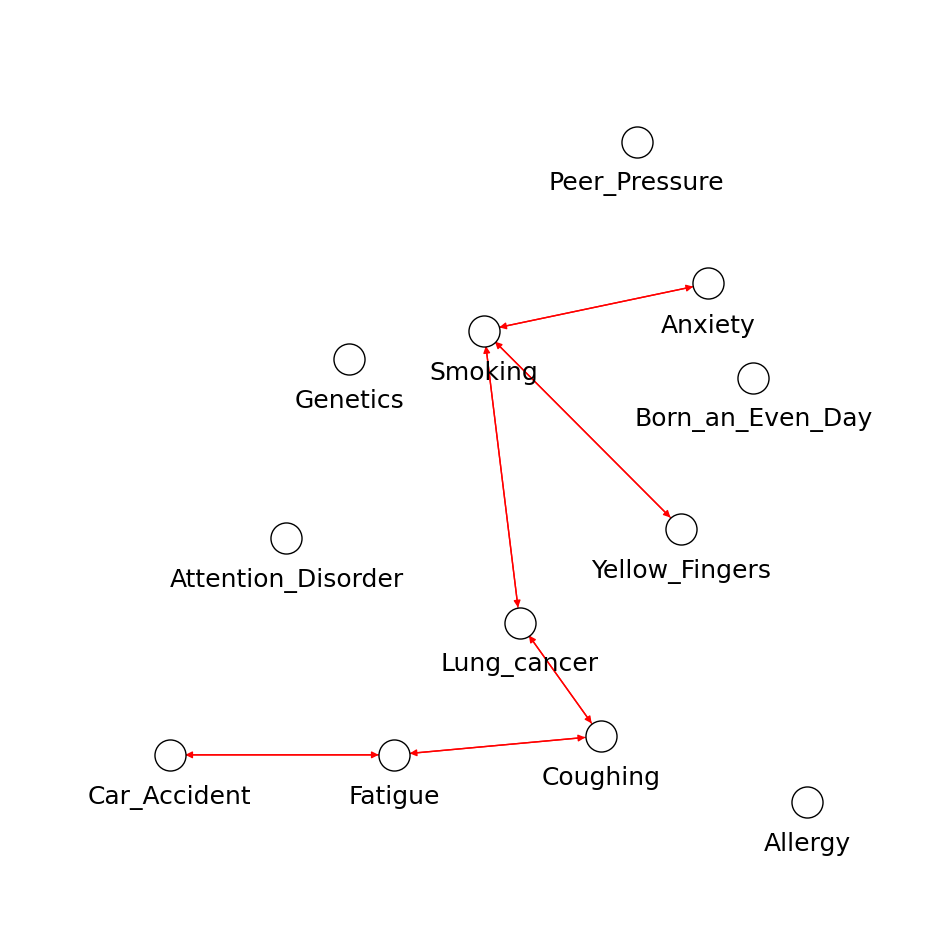

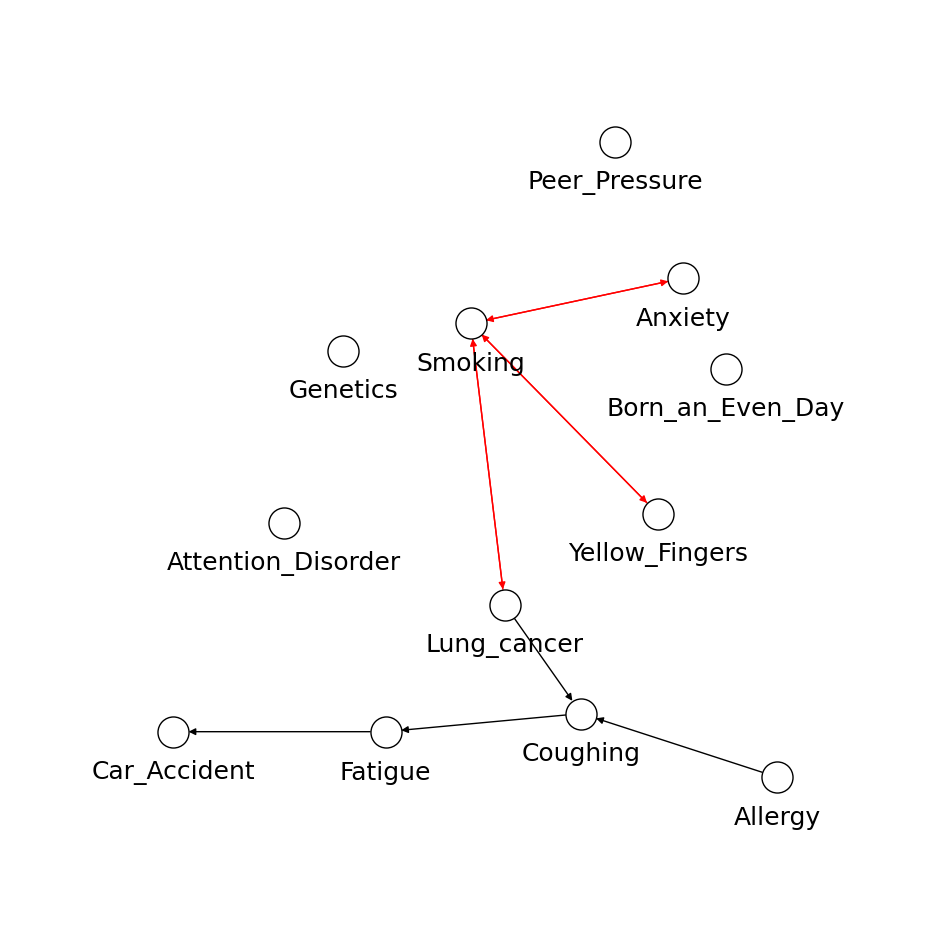

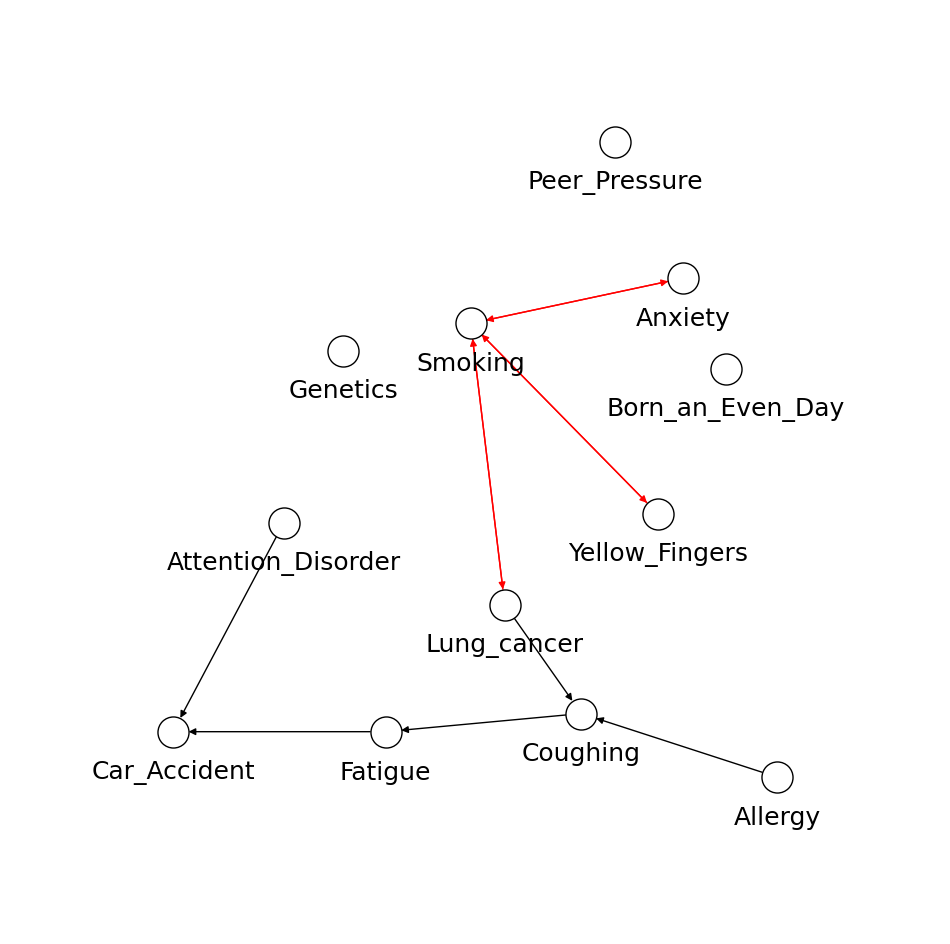

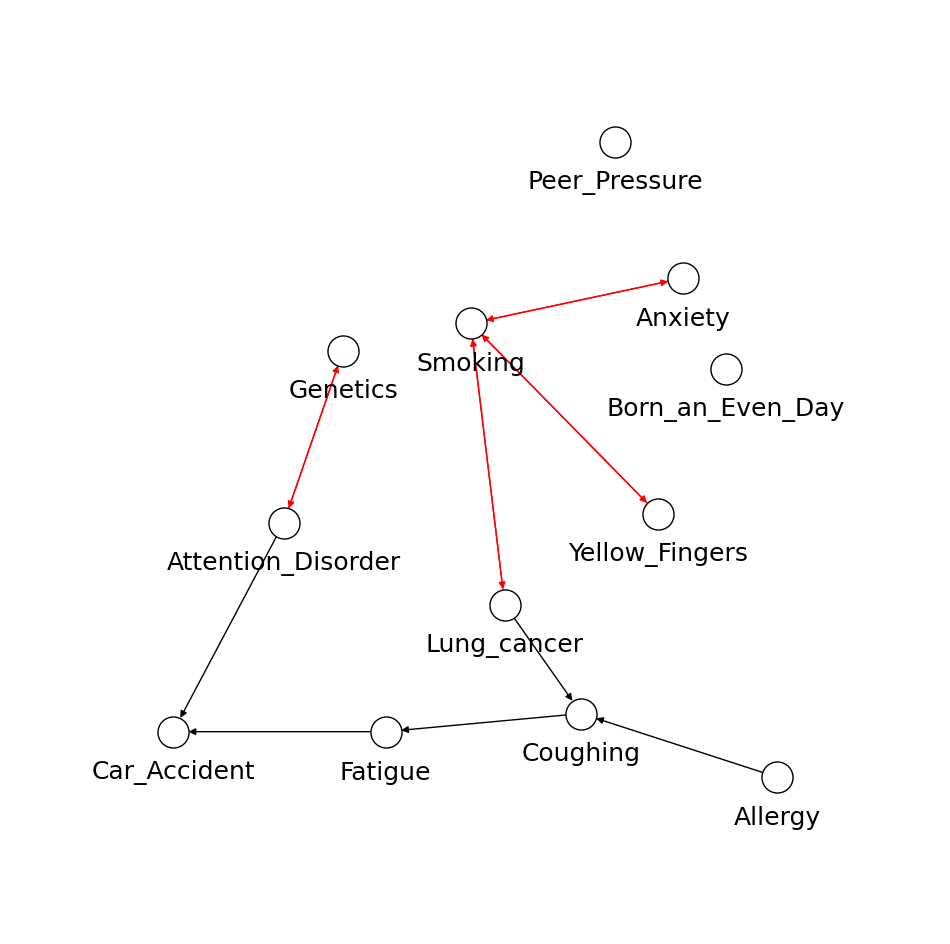

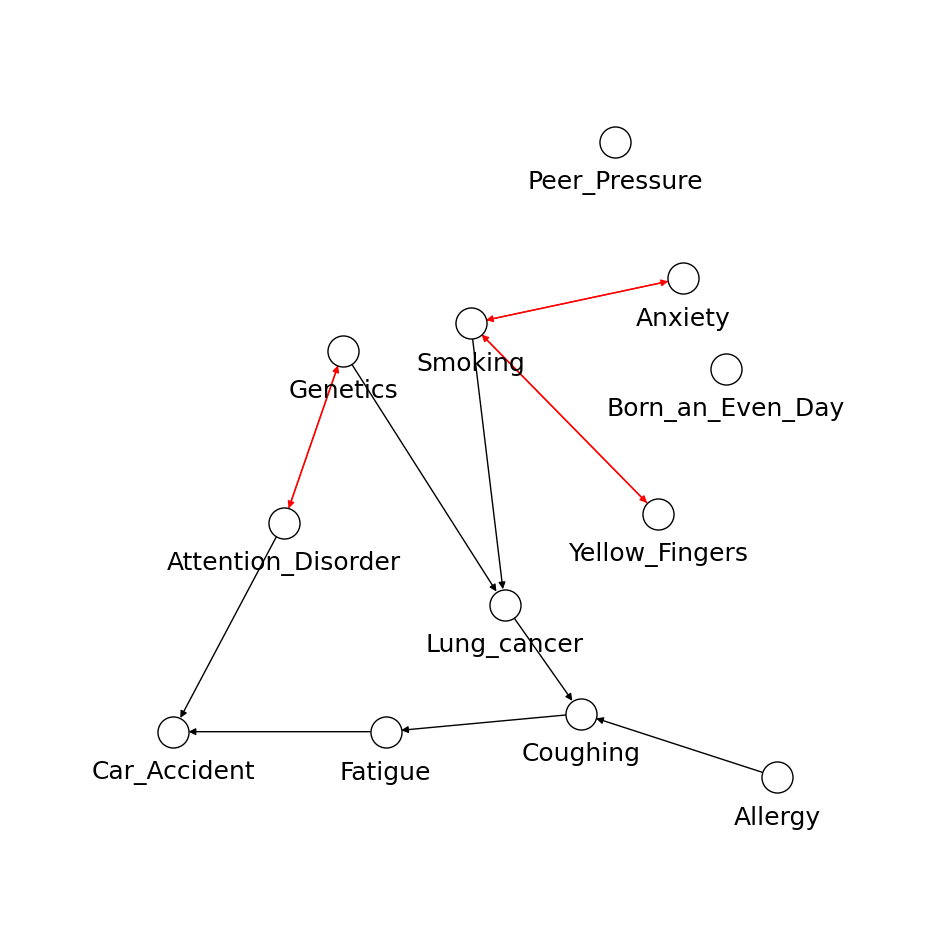

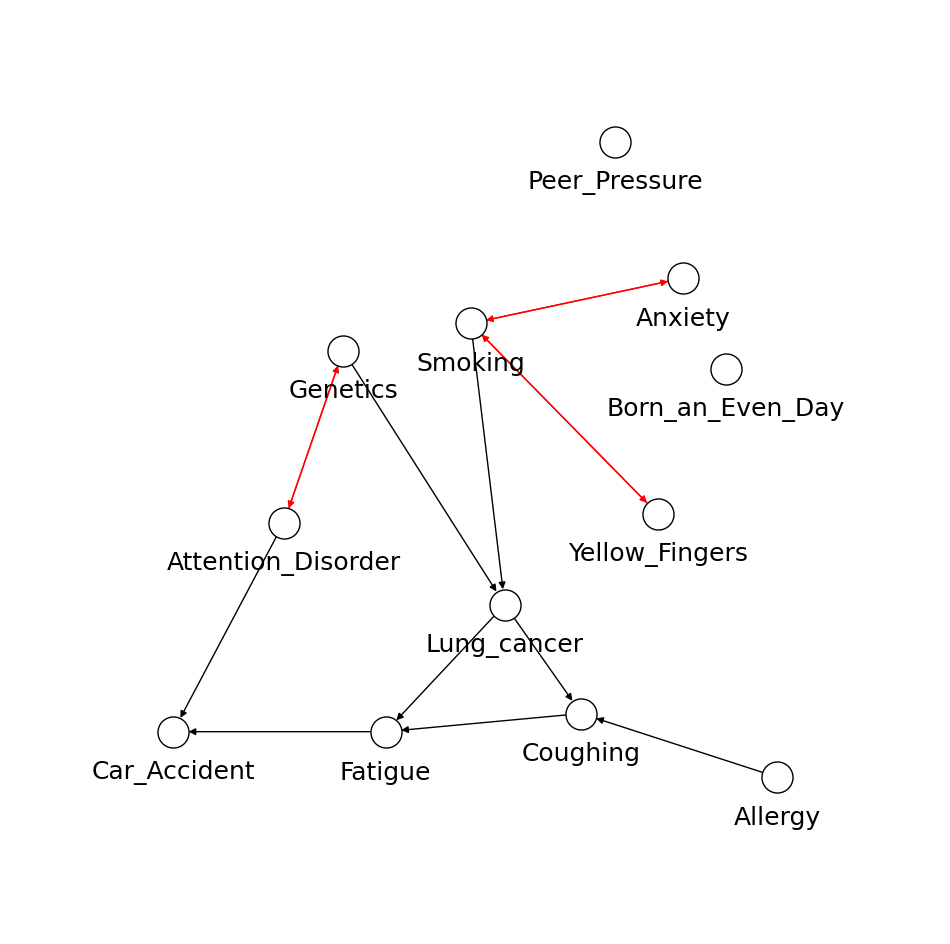

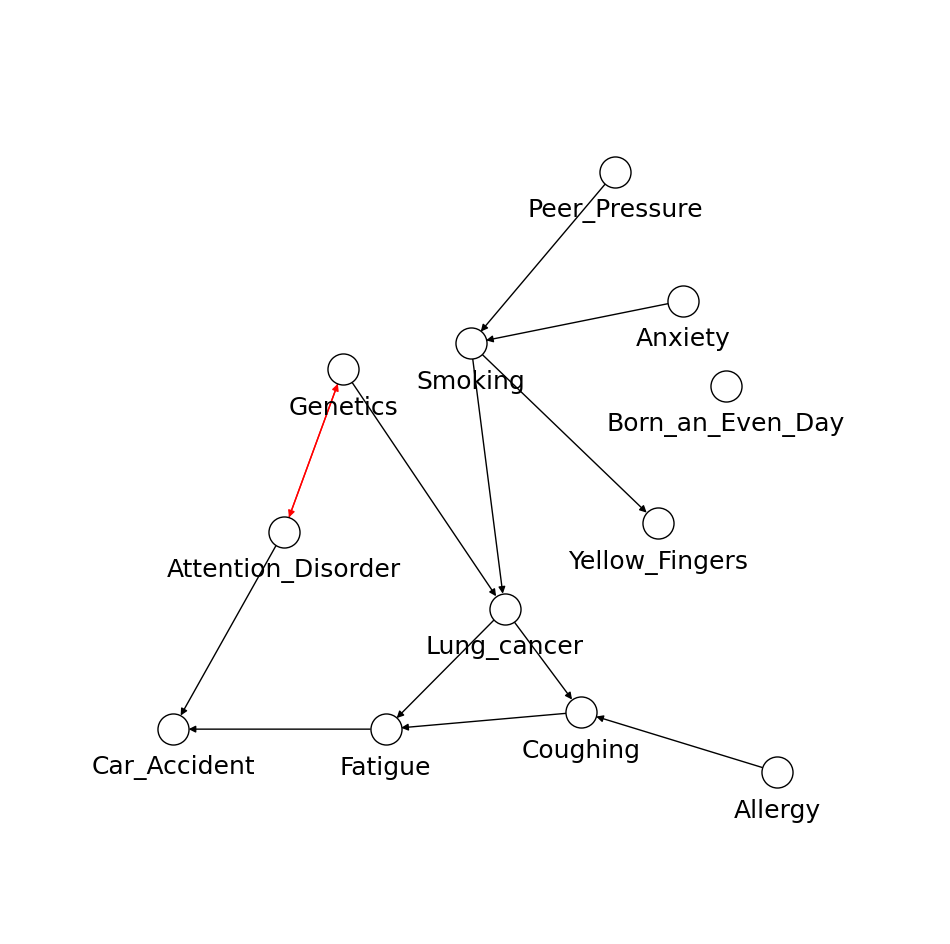

In [19]:
i = 0
for adj, score, phase in zip(inter_adjs, inter_scores, inter_phases):
    i+=1
    G = nx.relabel_nodes(nx.DiGraph(adj), {idx: i for idx, i in enumerate(df.columns)})
    colors = ['red'  if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]

    draw_graph(G)
    plt.savefig('GES/' + str(i) + '.png')

### End-to-end
If we only care about the end result, then we can simply call the `fit_bic` function ([reference](https://github.com/juangamella/ges#using-the-gaussian-bic-score-gesfit_bic)). This includes a "turning phase" (https://www.jmlr.org/papers/volume13/hauser12a/hauser12a.pdf) that improves the GES algorithm, which we did not cover in the class or this tutorial. The parameters of this function allow you to turn the turning phase off, as well as define the initial CPDAG and control whether you wish to run phases in a loop. However, the standard parameters should work best for most cases.

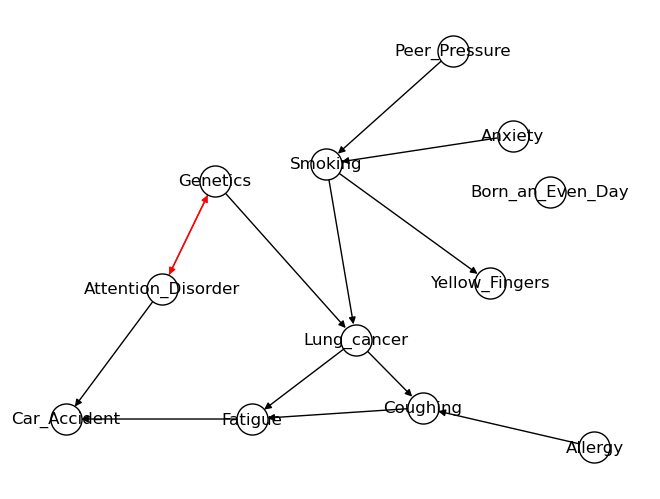

In [20]:
result, score = ges.fit_bic(df.to_numpy()) # The result is a CPDAG represented by an adjacency matrix
ges_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in ges_graph.edges() else 'black' for (x,y) in ges_graph.edges()]
nx.draw(ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

If you prefer to not convert your dataframe to a numpy array manually, you can use the `dowhy` wrapper for the ges package instead ([reference](https://www.pywhy.org/dowhy/v0.9.1/dowhy.graph_learners.html#dowhy.graph_learners.ges.GES)).

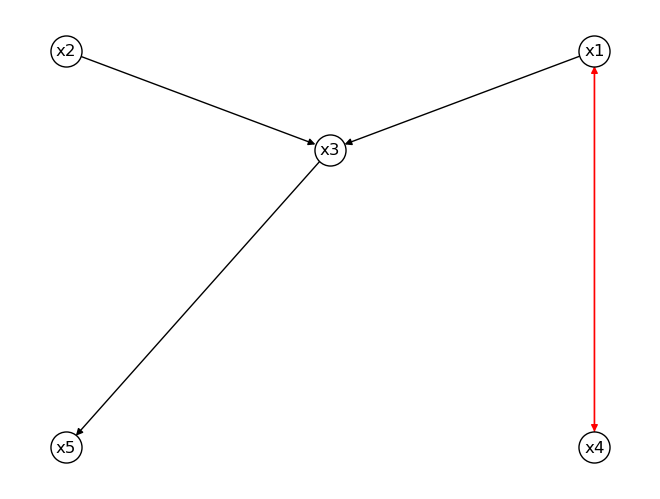

In [ ]:
learner = dowhy_ges.GES(df, 'ges') # Notice that we don't pass df.to_numpy()
learner.learn_graph()
dowhy_ges_graph = nx.relabel_nodes(nx.DiGraph(learner._adjacency_matrix), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in dowhy_ges_graph.edges() else 'black' for (x,y) in dowhy_ges_graph.edges()]
nx.draw(dowhy_ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

You can also use the GES wrapper from the `cdt` package as shown below ([reference](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html?highlight=ges#ges)).

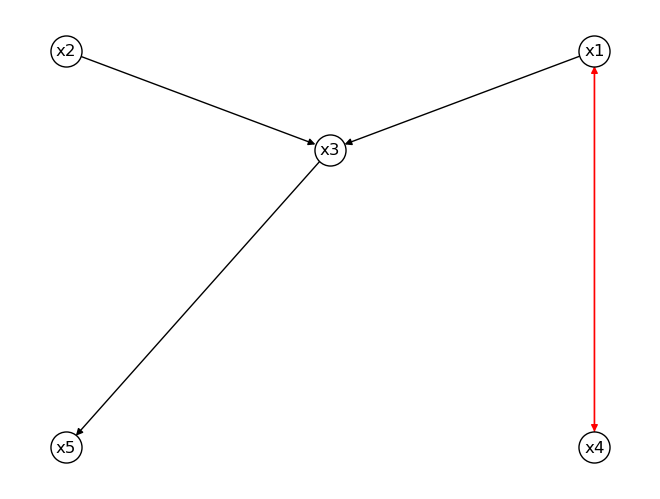

In [ ]:
cdt_gres_graph = cdt.causality.graph.GES(score='obs').predict(df)
colors = ['red'  if (y,x) in cdt_gres_graph.edges() else 'black' for (x,y) in cdt_gres_graph.edges()]
nx.draw(cdt_gres_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)